<a href="https://colab.research.google.com/github/RomaA2000/face_detecting/blob/master/TestFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd
import json
import codecs
import math
import requests
from PIL import Image
from tqdm import tqdm
from io import BytesIO
import torchvision
import matplotlib.pyplot as plt
import torch
import copy
from torchvision import transforms
import shutil
from PIL import Image
import os
import random
import gc
from skimage.feature import hog
from skimage import data, exposure

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

torch.backends.cuda.deterministic = True

from google.colab import drive
drive.mount('/content/drive')

#Выбрать нужный путь до данных
dir_name = '/content/drive/My Drive/Data'

Mounted at /content/drive


In [0]:
x_size = 256
y_size = 256

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return (self.data[0][idx], self.data[1][idx])
      
train_transforms = transforms.Compose([
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor()
])

val_transforms = transforms.Compose([
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor()
])

train_dir = os.path.join(dir_name, 'train')
val_dir = os.path.join(dir_name, 'val')

In [18]:
print(os.listdir('/content/drive/My Drive/Data/train'))

['answers', 'pic0.npy', 'pic1.npy', 'pic2.npy', 'pic3.npy', 'pic4.npy', 'pic8.npy', 'pic5.npy', 'pic9.npy', 'pic6.npy', 'pic15.npy', 'pic10.npy', 'pic7.npy', 'pic11.npy', 'pic16.npy', 'pic22.npy', 'pic12.npy', 'pic17.npy', 'pic23.npy', 'pic13.npy', 'pic24.npy', 'pic18.npy', 'pic14.npy', 'pic25.npy', 'pic19.npy', 'pic26.npy', 'pic38.npy', 'pic20.npy', 'pic27.npy', 'pic21.npy', 'pic39.npy', 'pic28.npy', 'pic40.npy', 'pic41.npy', 'pic29.npy', 'pic46.npy', 'pic42.npy', 'pic30.npy', 'pic47.npy', 'pic43.npy', 'pic31.npy', 'pic48.npy', 'pic32.npy', 'pic44.npy', 'pic49.npy', 'pic33.npy', 'pic45.npy', 'pic50.npy', 'pic34.npy', 'pic55.npy', 'pic51.npy', 'pic35.npy', 'pic56.npy', 'pic52.npy', 'pic36.npy', 'pic57.npy', 'pic53.npy', 'pic37.npy', 'pic58.npy', 'pic54.npy', 'pic62.npy', 'pic59.npy', 'pic76.npy', 'pic63.npy', 'pic60.npy', 'pic77.npy', 'pic61.npy', 'pic64.npy', 'pic78.npy', 'pic65.npy', 'pic79.npy', 'pic66.npy', 'pic86.npy', 'pic80.npy', 'pic67.npy', 'pic87.npy', 'pic81.npy', 'pic68.npy

In [6]:
def arr_maker(data_dir, size, transforms_data):
    answers = []
    pics = []
    for idx in tqdm(range(size)):
      pics.append(transforms_data(Image.fromarray(np.load(os.path.join(data_dir, "pic" + str(idx) + '.npy')))))
      answers.append(transforms_data(Image.fromarray(np.load(os.path.join(data_dir, 'answers', 'ans' + str(idx) + '.npy')))))
    return (pics, answers)

train_dataset = Dataset(arr_maker(train_dir, 710, train_transforms))
val_dataset = Dataset(arr_maker(val_dir, 142, val_transforms))


100%|██████████| 142/142 [03:19<00:00,  1.28s/it]


In [19]:
#Подбираемые параметры
#Если не указаны границы пожно увеличивать пока не упадет CUDA
size = 25
koef = 1
#^ 0 - 10 ^# 
batch_size = 16

new_name = os.path.join(dir_name, 'results', "k_" + str(koef) + "_s_" + str(size) + "_b_" + str(batch_size) + "_size_" + str(x_size))
print(new_name)

num_work = 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_work)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_work)


/content/drive/My Drive/Data/results/k_1_s_25_b_16_size_256


In [20]:
print(os.listdir('/content/drive'))
os.mkdir(new_name)

['My Drive', '.Trash']


In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs, k):

    sub_min = 1.
    top_model = model
    history = [[], []]
    history_2 = [[], []]
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            sub_max_epoch = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels *= k
                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    sub_max_epoch = max(torch.max(torch.abs((labels - preds))).item(), sub_max_epoch)
                    loss_value = loss(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        scheduler.step()
                        optimizer.step()
                # statistics
                running_loss += loss_value.item()

            epoch_loss = running_loss / len(dataloader)

            print('{} Sub max: {:.4f} Loss: {:.4f}'.format(phase, sub_max_epoch, epoch_loss), flush=True)
            
            if (phase == 'val'):
                history[0].append(epoch_loss)
                history[1].append(epoch)
                print(sub_max_epoch)
                fig, graph = plt.subplots(figsize=(13,8))
                graph.plot(history[1], history[0], 'o', linestyle='solid')
                plt.show()
                plt.pause(0.001)
                for number in 5, 21, 23:
                    print(os.listdir('/content/drive/My Drive/Data'))
                    test = train_transforms(Image.fromarray(np.load(os.path.join(val_dir, "pic" + str(number) + '.npy')))) 
                    plt.imshow(test[0]) 
                    plt.pause(0.001) 
                    inp = torch.zeros((1, test.shape[0], test.shape[1], test.shape[2])) 
                    inp[0] = test 
                    inp = inp.to(device) 
                    res = model(inp).cpu()[0] 
                    inp = inp.to('cpu')
                    plt.imshow(res.detach().numpy()[0]) 
                    plt.pause(0.001)
                    plt.imshow(val_dataset.__getitem__(number)[1][0]) 
                    plt.pause(0.001)
                    np.save(os.path.join(new_name, "out_" + str(epoch) + '-' + str(number)), res.detach().numpy()[0])
                    print('ver 1')
            if (phase == 'val' and sub_min > sub_max_epoch):
                sub_min = sub_max_epoch
            
            gc.collect()
            torch.cuda.empty_cache() 
    return top_model

In [0]:
class FaceNet(torch.nn.Module):
    def __init__(self, size):
        super(FaceNet, self).__init__()
        kernel_size = size
        padding = (kernel_size // 2)
        self.con1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac1 = torch.nn.PReLU()
        self.con2 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac2 = torch.nn.PReLU()
        self.con3 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac3 = torch.nn.PReLU()
        self.con4 = torch.nn.Conv2d(in_channels=8, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.ac4 = torch.nn.PReLU()
        self.con5 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.ac5 = torch.nn.PReLU()
        self.con6 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.ac6 = torch.nn.PReLU()
        self.con7 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding)
        self.ac7 = torch.nn.PReLU()
        self.con8 = torch.nn.Conv2d(in_channels=64, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac8 = torch.nn.PReLU()
        self.con9 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac9 = torch.nn.PReLU()
        self.con10 = torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=kernel_size, padding=padding)
        self.ac10 = torch.nn.PReLU()
        self.con11 = torch.nn.Conv2d(in_channels=8, out_channels=1, kernel_size=kernel_size, padding=padding)
        self.ac11 = torch.nn.Sigmoid()
        
        
        self.bn_2d_0 = torch.nn.BatchNorm2d(1)
        self.bn_2d_1 = torch.nn.BatchNorm2d(8)
        self.bn_2d_2 = torch.nn.BatchNorm2d(8)
        self.bn_2d_3 = torch.nn.BatchNorm2d(8)
        self.bn_2d_4 = torch.nn.BatchNorm2d(64)
        self.bn_2d_5 = torch.nn.BatchNorm2d(64)
        self.bn_2d_6 = torch.nn.BatchNorm2d(64)
        self.bn_2d_7 = torch.nn.BatchNorm2d(64)
        self.bn_2d_8 = torch.nn.BatchNorm2d(8)
        self.bn_2d_9 = torch.nn.BatchNorm2d(8)
        self.bn_2d_10 = torch.nn.BatchNorm2d(8)

    def forward(self, x):
        x = self.bn_2d_0(x)
        x = self.ac1(self.con1(x))
        x = self.bn_2d_1(x)
        x = self.ac2(self.con2(x))
        x = self.bn_2d_2(x)
        x = self.ac3(self.con3(x))
        x = self.bn_2d_3(x)
        x = self.ac4(self.con4(x))
        x = self.bn_2d_4(x)
        x = self.ac5(self.con5(x))
        x = self.bn_2d_5(x)
        x = self.ac6(self.con6(x))
        x = self.bn_2d_6(x)
        x = self.ac7(self.con7(x))
        x = self.bn_2d_7(x)
        x = self.ac8(self.con8(x))
        x = self.bn_2d_8(x)
        x = self.ac9(self.con9(x))
        x = self.bn_2d_9(x)
        x = self.ac10(self.con10(x))
        x = self.bn_2d_10(x)
        x = self.ac11(self.con11(x))
        return x;



In [0]:
model = FaceNet(size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.MSELoss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3, amsgrad=True) #, momen)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=0.75)

Epoch 0/99:



  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

100%|██████████| 45/45 [32:59<00:00, 36.75s/it]


train Sub max: 18.3199 Loss: 1806533.2382



100%|██████████| 9/9 [03:07<00:00, 20.31s/it]


val Sub max: 15.9803 Loss: 2148123.9931
15.980347633361816


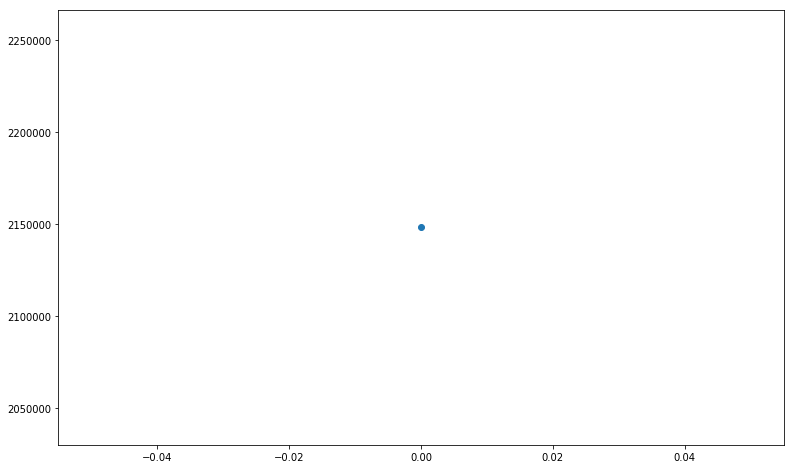

['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


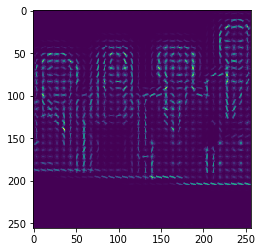

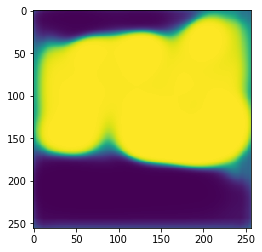

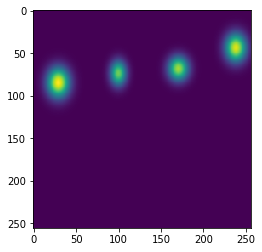

ver 1
['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


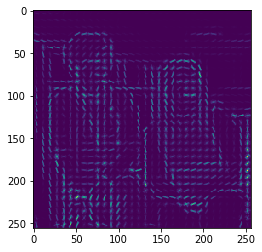

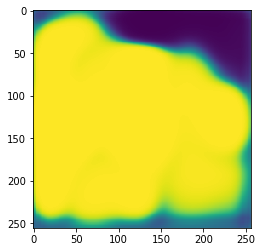

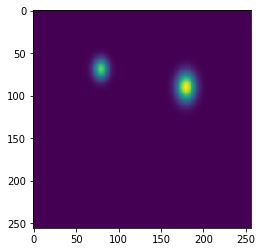

ver 1
['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


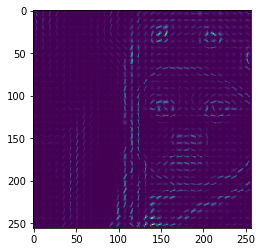

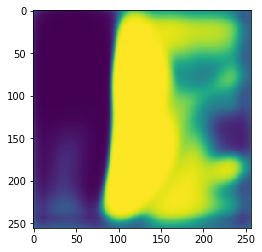

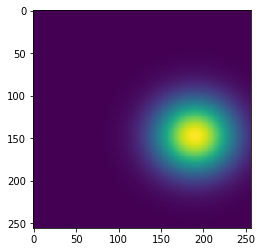

ver 1
Epoch 1/99:



100%|██████████| 45/45 [32:59<00:00, 36.76s/it]


train Sub max: 18.3413 Loss: 1757670.9333



100%|██████████| 9/9 [03:07<00:00, 20.33s/it]


val Sub max: 16.5222 Loss: 2044778.3403
16.522165298461914


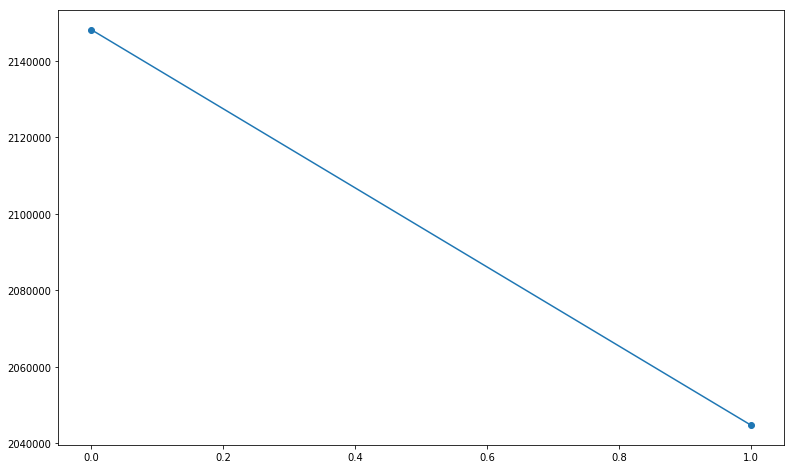

['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


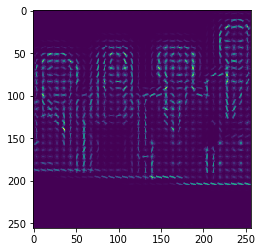

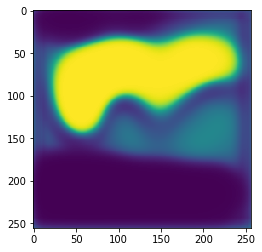

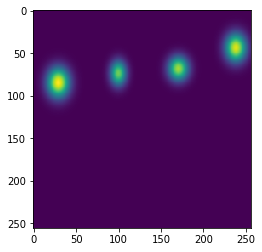

ver 1
['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


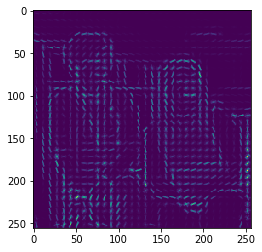

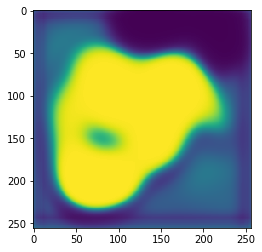

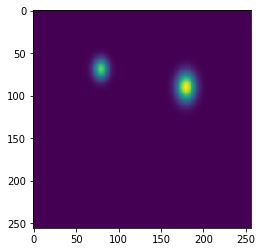

ver 1
['val', 'train', 'results', 'best', 'test', 'information', 'Копия TestFace.ipynb', 'Копия Choiser.ipynb']


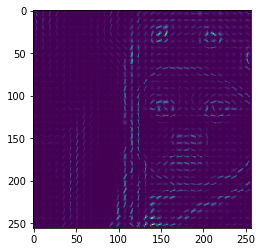

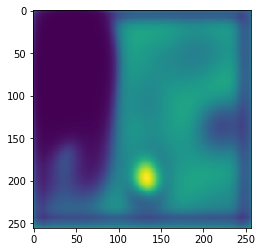

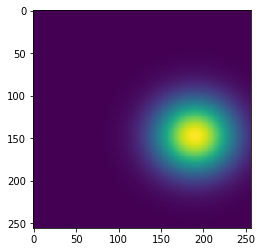

ver 1
Epoch 2/99:



 36%|███▌      | 16/45 [11:53<21:31, 44.53s/it]

In [0]:
gc.collect()
model = train_model(model, loss, optimizer, scheduler, num_epochs=100, k=koef)
